### Workflow for getting composition for each roi annotation for each DLmask (DLmask generated from entire mask of ndpi):

In [1]:
OPENSLIDE_PATH = r'C:\Users\Kevin\Desktop\openslide-win64-20221217\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Python >= 3.8 on Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [2]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import os
import cv2
Image.MAX_IMAGE_PIXELS = 1000000000000000000
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import openslide
from PIL import Image
from matplotlib import pyplot as plt
import skimage.measure
import matplotlib.pyplot as plt
import scipy.stats as stats
import torchvision.transforms as transforms
from glob import glob
from time import time
from skimage.measure import label
import math

In [3]:
# quick pandas work to see if ndpi's in image list have the DL segmented masks!
# read xml files for roi annotations
roi_src = r'\\shelter\Kyu\skin_aging\clue_cohort\annotations\roi'
# read DL mask files for DL segmented masks
dl_src = r'\\shelter\Kyu\skin_aging\clue_cohort\DLmask1um'
# read image list and fill in DL_segmented column (0=DLmask missing, 1=DLmask exists)
im_list = r'\\shelter\Kyu\skin_aging\clue_cohort\CLUE_image_list_230207.xlsx'

In [4]:
roi_list = [x for x in os.listdir(roi_src) if x.endswith('.xml')] #301 rows
dl_list = [x for x in os.listdir(dl_src) if x.endswith('.tif')] #301 rows
roi_complete_path = [os.path.join(roi_src,x) for x in roi_list]
dl_complete_path = [os.path.join(dl_src,x) for x in dl_list]
roi_raw = [x.replace(".xml","") for x in roi_list]
dl_raw = [x.replace(".tif","") for x in dl_list]

In [5]:
# image_list_csv_raw = pd.read_excel(r'\\shelter\Kyu\skin_aging\clue_cohort\CLUE_image_list_230207.xlsx')

In [6]:
# dl_list = [x.replace(".tif","") for x in dl_list]

In [7]:
# def check_DLexist(row):
#     row = row.replace('.ndpi','')
#     return row in dl_list

In [8]:
# image_list_csv_raw['DL_segmented'] = image_list_csv_raw.apply(lambda row : check_DLexist(row['filename']), axis = 1)

In [9]:
# image_list_csv_raw.head()

In [10]:
# image_list_csv_raw.to_excel(r'\\shelter\Kyu\skin_aging\clue_cohort\CLUE_image_list_230207_v2.xlsx')

In [11]:
# First, input xml_filepath and output a dataframe of X,Y coordinates in general. (can be used for ROI as well)
def xml_to_df(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    append_df = []
    for index, Annotation in enumerate(root.iter("Annotation")):
        for Region in Annotation.iter('Region'):
            x = np.array([Vertex.get('X') for Vertex in Region.iter('Vertex')])
            y = np.array([Vertex.get('Y') for Vertex in Region.iter('Vertex')])
            id = np.array([int(Region.get('Id'))])
            classnames = index + 1
            coord_dict = {"ClassNames": [classnames], "X": [x], "Y": [y], "ID": [id]}
            df = pd.DataFrame(data = coord_dict)
            df.ID = df.ID.astype(int)
            append_df.append(df)
    coord_df = pd.concat(append_df).reset_index(drop=True)
    return(coord_df)

In [12]:
# Then input original image and the coord_df to output the mask with unique annotations (1..N, N = 12 in this case):
def create_mask_multi_annot(xml_path, image_path): #choose downsample factor
    slide = openslide.open_slide(image_path)
    target_dim = [math.ceil(x / 2.26459) for x in slide.dimensions]
    # target_level = slide.get_best_level_for_downsample(downsample_factor)
    # target_dim = slide.level_dimensions[target_level]
    # rsf = [x/y for x,y in zip(slide.dimensions,target_dim)] #resize factor
    mask = np.zeros((target_dim), dtype = np.uint8)
    coord_df = xml_to_df(xml_path) #use function above
    for idx, row in coord_df.iterrows():
        xx = row.X.astype(float).astype('int32')
        xx = [math.ceil(x / 2.26459) for x in xx]
        yy = row.Y.astype(float).astype('int32')
        yy = [math.ceil(x / 2.26459) for x in yy]
        contours = np.array(list(zip(xx,yy)))
        mask = cv2.fillPoly(mask, pts=[contours.astype(int)], color=(int(coord_df.index.values[idx]) + 1))
    return mask

ClassNames                                                    1
X             [79364, 79407, 79449, 79481, 79524, 79556, 795...
Y             [11110, 11121, 11142, 11153, 11153, 11174, 111...
ID                                                            3
Name: 0, dtype: object
ClassNames                                                    1
X             [66929, 66951, 66983, 67015, 67057, 67100, 671...
Y             [9027, 9048, 9059, 9091, 9102, 9134, 9145, 916...
ID                                                            4
Name: 1, dtype: object
ClassNames                                                    1
X             [42154, 42165, 42176, 42197, 42197, 42208, 422...
Y             [17392, 17413, 17413, 17413, 17424, 17434, 174...
ID                                                            5
Name: 2, dtype: object
ClassNames                                                    1
X             [9225, 9240, 9240, 9254, 9269, 9269, 9284, 929...
Y             [15325, 15340, 15355,

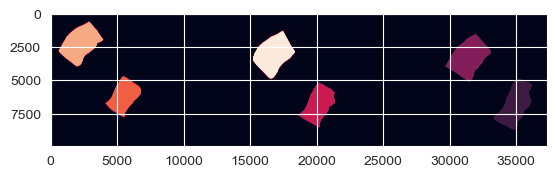

In [17]:
# coord_df = xml_to_df(r'\\shelter\Kyu\skin_aging\clue_cohort\annotations\roi\2022-06-10 16.39.33.xml')
# mask = np.zeros((9948,37305), dtype = np.uint8)
# for idx, row in coord_df.iterrows():
#     print(row)
#     xx = row.X.astype(float).astype('int32')
#     xx = [math.ceil(x / 2.26459) for x in xx]
#     yy = row.Y.astype(float).astype('int32')
#     yy = [math.ceil(x / 2.26459) for x in yy]
#     contours = np.array(list(zip(xx,yy)))
#     mask = cv2.fillPoly(mask, pts=[contours.astype(int)], color=(int(coord_df.index.values[idx] + 1)))
#     plt.imshow(mask)

In [13]:
# find intersection of ndpi, roi, and dl -> A ∩ B ∩ C = (A ∩ B) ∩ (B ∩ C), roi = A, dl = B, ndpi = C

ndpi_src = r'\\shelter\Kyu\skin_aging\clue_cohort\wsi'
ndpi_list = [x for x in os.listdir(ndpi_src) if x.endswith('.ndpi')] #301 rows
ndpi_raw = [x.replace(".ndpi","") for x in ndpi_list]

roi_dl_overlap = set(roi_raw).intersection(set(dl_raw)) #216
dl_ndpi_overlap = set(dl_raw).intersection(set(ndpi_raw)) #222
all_overlap = set(roi_dl_overlap).intersection(set(dl_ndpi_overlap)) #216

dl_complete_path_new = [os.path.join(dl_src,x) for x in all_overlap]
roi_complete_path_new = [os.path.join(roi_src,x) for x in all_overlap]
ndpi_complete_path_new = [os.path.join(ndpi_src,x) for x in all_overlap]
dl_complete_path_new = [x + ".tif" for x in dl_complete_path_new]
roi_complete_path_new = [x + ".xml" for x in roi_complete_path_new]
ndpi_complete_path_new = [x + ".ndpi" for x in ndpi_complete_path_new]
save_name = [os.path.basename(x) for x in ndpi_complete_path_new]

In [15]:
# read a first DLmask and its corresponding roi xml file
roi_png_dst = os.path.join(roi_src,'roi_png_1x') # destination to save grayscale labeled mask
comps_df = pd.DataFrame()
for idx in range(0,len(dl_complete_path_new)):
    print(dl_complete_path_new[idx])
    DLarr = Image.open(dl_complete_path_new[idx])
    mask = create_mask_multi_annot(roi_complete_path_new[idx], ndpi_complete_path_new[idx]) #, downsample_factor= 2.264596)
    mask = mask.T
    roi_png = Image.fromarray(mask)
    roi_png.save(os.path.join(roi_png_dst,save_name[idx].replace("ndpi","png"))) # save labeled mask
#for example of roi_png: "\\shelter\Kyu\skin_aging\clue_cohort\annotations\roi\labeledmask_20rsf", roi_png is an image with grayscale labeled mask, save this.
    for sectionID in range(1,np.max(roi_png)+1):
        print("max roi png is", np.max(roi_png))
        roi_png = np.array(roi_png)
        roi_shape = roi_png.shape
        DLarr = np.array(DLarr)
        DLarr_shape = DLarr.shape

        if roi_shape != DLarr_shape:
            #resize DLarr to roi_shape
            DLarr = cv2.resize(DLarr,roi_shape,interpolation = cv2.INTER_LINEAR)
            DLarr = DLarr.T
            print("roi shape is", roi_shape)
            print("DLarr shape is", DLarr_shape)
        print("sectionID is",sectionID)
        DL_roi = DLarr[roi_png==sectionID] # for each roi in the image
        hist = np.bincount(DL_roi) #dl mask
        hist = hist/np.sum(hist)*100
        count_list = list(hist)
        count_list = [np.round(x,3) for x in count_list]
        print(count_list)
        # if idx == 0 and sectionID == 1: # first time, create xml_to_df
        #
        # else: # just concat df

#
# output composition data by roi
# comp_excel =
# xl_dst = r"\\shelter\Kyu\skin_aging\clue_cohort\CLUE_morphometrics_230207.xlsx"

\\shelter\Kyu\skin_aging\clue_cohort\DLmask1um\2022-06-15 18.59.15.tif
max roi png is 4
roi shape is (16788, 25436)
DLarr shape is (16788, 25435)
sectionID is 1
[]
max roi png is 4
sectionID is 2
[0.0, 0.355, 0.166, 0.004, 0.003, 0.004, 0.003, 0.013, 0.028, 0.146, 2.866, 0.327, 96.085]
max roi png is 4
sectionID is 3
[0.0, 0.442, 0.93, 0.038, 0.027, 0.396, 0.028, 0.354, 0.29, 0.896, 38.996, 2.641, 54.963]
max roi png is 4
sectionID is 4
[0.0, 1.203, 1.611, 0.11, 0.118, 0.418, 0.456, 0.334, 0.427, 1.297, 44.837, 7.528, 41.662]
\\shelter\Kyu\skin_aging\clue_cohort\DLmask1um\2022-07-07 15.34.12.tif
\\shelter\Kyu\skin_aging\clue_cohort\DLmask1um\2022-06-09 19.01.26.tif
max roi png is 2
sectionID is 1
[0.0, 5.673, 2.244, 0.505, 0.535, 0.447, 0.921, 0.835, 0.763, 2.672, 47.112, 5.674, 32.619]
max roi png is 2
sectionID is 2
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0]
\\shelter\Kyu\skin_aging\clue_cohort\DLmask1um\2022-06-09 20.18.08.tif
max roi png is 1
sectionID is 1


KeyboardInterrupt

